# 왜 학습용 데이터랑 테스트 데이터랑 안 나눴니... 나 자신아!

In [1]:
import cv2
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import subprocess
import os

from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [ ]:
np.random.seed(1)

In [ ]:
np.random.rand(5)

In [41]:
log_files = os.listdir('../logSplitDataset')

In [42]:
test_log_files = random.sample(log_files, int(len(log_files) * 0.2))
len(test_log_files)

793

In [43]:
print(len(log_files))
print(len(test_log_files))

3965
793


In [44]:
train_log_files = log_files
for i in test_log_files:
    train_log_files.remove(i)
    
print(len(train_log_files))

3172


In [45]:
test_log_files.sort()
test_log_files

['2020-08-24_10-07-1.csv',
 '2020-08-24_10-15-1.csv',
 '2020-08-24_10-20-1.csv',
 '2020-08-24_10-32-1.csv',
 '2020-08-24_10-34-1.csv',
 '2020-08-24_10-37-1.csv',
 '2020-08-24_10-51-1.csv',
 '2020-08-24_10-56-1.csv',
 '2020-08-24_10-59-1.csv',
 '2020-08-24_11-09-1.csv',
 '2020-08-24_11-10-1.csv',
 '2020-08-24_11-15-1.csv',
 '2020-08-24_11-22-1.csv',
 '2020-08-24_11-30-1.csv',
 '2020-08-24_11-32-1.csv',
 '2020-08-24_11-34-1.csv',
 '2020-08-24_11-37-1.csv',
 '2020-08-24_11-54-1.csv',
 '2020-08-24_11-58-1.csv',
 '2020-08-24_12-00-1.csv',
 '2020-08-24_12-17-0.csv',
 '2020-08-24_12-21-0.csv',
 '2020-08-24_12-23-0.csv',
 '2020-08-24_12-24-0.csv',
 '2020-08-24_12-29-0.csv',
 '2020-08-24_12-31-1.csv',
 '2020-08-24_12-49-1.csv',
 '2020-08-24_12-57-1.csv',
 '2020-08-24_13-12-1.csv',
 '2020-08-24_13-19-1.csv',
 '2020-08-24_13-30-1.csv',
 '2020-08-24_13-36-1.csv',
 '2020-08-24_13-38-1.csv',
 '2020-08-24_13-43-1.csv',
 '2020-08-24_13-45-1.csv',
 '2020-08-24_13-47-1.csv',
 '2020-08-24_13-53-1.csv',
 

In [51]:
train_log_files.sort()
train_log_files[4][-5]

'0'

# 분리한 파일명으로 각각 다른 폴더에 저장하기

In [52]:
for fileName in test_log_files:
    imgFileName = fileName.replace('.csv', '.png')
    
    out = subprocess.check_output(['xxd','-p',f'../logSplitDataset/{fileName}'])
    out = str(out)
#     print(out)
    out = out[2:-1].replace('\\n', '')
    length = 2
    outListHex = list(map(''.join, zip(*[iter(out)]*length)))
    outListInt = [int(x, 16) for x in outListHex]
    if len(outListInt) % 2 != 0:
        outListInt.append(0)
    outArray = np.array(outListInt)
    outArray = outArray.reshape(-1,2)
    
    empty = np.zeros([128, 128])
    empty = empty.astype('uint8')
    for x, y in outArray:
        empty[x, y] += 1
#         cv2.circle(empty, (x, y), 8, (255,255,255), 1)
#     print(empty)
    if imgFileName[-5] == '1':
        cv2.imwrite(f'../imgDataset/test/attack/{imgFileName}', empty)
    else:
        cv2.imwrite(f'../imgDataset/test/normal/{imgFileName}', empty)

In [53]:
for fileName in train_log_files:
    imgFileName = fileName.replace('.csv', '.png')
    
    out = subprocess.check_output(['xxd','-p',f'../logSplitDataset/{fileName}'])
    out = str(out)
#     print(out)
    out = out[2:-1].replace('\\n', '')
    length = 2
    outListHex = list(map(''.join, zip(*[iter(out)]*length)))
    outListInt = [int(x, 16) for x in outListHex]
    if len(outListInt) % 2 != 0:
        outListInt.append(0)
    outArray = np.array(outListInt)
    outArray = outArray.reshape(-1,2)
    
    empty = np.zeros([128, 128])
    empty = empty.astype('uint8')
    for x, y in outArray:
        empty[x, y] += 1
#         cv2.circle(empty, (x, y), 8, (255,255,255), 1)
#     print(empty)
    if imgFileName[-5] == '1':
        cv2.imwrite(f'../imgDataset/train/attack/{imgFileName}', empty)
    else:
        cv2.imwrite(f'../imgDataset/train/normal/{imgFileName}', empty)

# 이제 나눠진 파일로 다시 모델을 만들어보자!


In [2]:
import os

In [3]:
print(len(os.listdir('../imgDataset/test/attack')))
print(len(os.listdir('../imgDataset/test/normal')))
print(len(os.listdir('../imgDataset/train/attack')))
print(len(os.listdir('../imgDataset/train/normal')))

299
494
1225
1948


In [4]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [5]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

In [6]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

In [7]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(128, 128, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # 이전 CNN 레이어에서 나온 3차원 배열은 1차원으로 뽑아줍니다
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [8]:
batch_size = 16

# 학습 이미지에 적용한 augmentation 인자를 지정해줍니다.
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# 검증 및 테스트 이미지는 augmentation을 적용하지 않습니다. 모델 성능을 평가할 때에는 이미지 원본을 사용합니다.
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
# 이미지를 배치 단위로 불러와 줄 generator입니다.
train_generator = train_datagen.flow_from_directory(
        '../imgDataset/train',  # this is the target directory
        target_size=(128, 128),  # 모든 이미지의 크기가 150x150로 조정됩니다.
        batch_size=batch_size,
        class_mode='binary')  # binary_crossentropy 손실 함수를 사용하므로 binary 형태로 라벨을 불러와야 합니다.

validation_generator = validation_datagen.flow_from_directory(
        '../imgDataset/test',
        target_size=(128, 128),
        batch_size=batch_size,
        class_mode='binary')

test_generator = test_datagen.flow_from_directory(
        '../imgDataset/test',
        target_size=(128, 128),
        batch_size=batch_size,
        class_mode='binary')

Found 3172 images belonging to 2 classes.
Found 793 images belonging to 2 classes.
Found 793 images belonging to 2 classes.


In [15]:
model.fit(train_generator, steps_per_epoch=batch_size, validation_data=validation_generator, epochs=1)
model.save_weights('conan_ver_02.h5')

ValueError: in user code:

    /usr/local/Caskroom/miniconda/base/envs/py_env/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /usr/local/Caskroom/miniconda/base/envs/py_env/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/Caskroom/miniconda/base/envs/py_env/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/Caskroom/miniconda/base/envs/py_env/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/Caskroom/miniconda/base/envs/py_env/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/Caskroom/miniconda/base/envs/py_env/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /usr/local/Caskroom/miniconda/base/envs/py_env/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:749 train_step
        y, y_pred, sample_weight, regularization_losses=self.losses)
    /usr/local/Caskroom/miniconda/base/envs/py_env/lib/python3.7/site-packages/tensorflow/python/keras/engine/compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /usr/local/Caskroom/miniconda/base/envs/py_env/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:149 __call__
        losses = ag_call(y_true, y_pred)
    /usr/local/Caskroom/miniconda/base/envs/py_env/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:253 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /usr/local/Caskroom/miniconda/base/envs/py_env/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /usr/local/Caskroom/miniconda/base/envs/py_env/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:1605 binary_crossentropy
        K.binary_crossentropy(y_true, y_pred, from_logits=from_logits), axis=-1)
    /usr/local/Caskroom/miniconda/base/envs/py_env/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /usr/local/Caskroom/miniconda/base/envs/py_env/lib/python3.7/site-packages/tensorflow/python/keras/backend.py:4823 binary_crossentropy
        return nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)
    /usr/local/Caskroom/miniconda/base/envs/py_env/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /usr/local/Caskroom/miniconda/base/envs/py_env/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:174 sigmoid_cross_entropy_with_logits
        (logits.get_shape(), labels.get_shape()))

    ValueError: logits and labels must have the same shape ((None, 2) vs (None, 1))


# 도대체 뭐가 문제일까... CNN 첨부터 다시해보자

In [16]:
from sklearn import datasets
import numpy.linalg as lin
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist, fashion_mnist
from keras import models
from keras.utils import to_categorical
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D
import cv2

In [17]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 1s 0us/step


In [18]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


[5 0 4 ... 5 6 8]


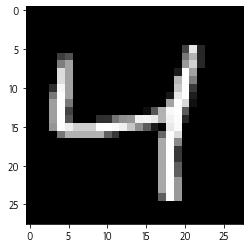

In [21]:
plt.imshow(X_train[2], cmap='gray')
print(y_train)

In [ ]:
# X는 이미지 행렬 y는 라벨링

In [ ]:
my_X_train = 